<a href="https://colab.research.google.com/github/julia-lina-tan/ot-policy-fusion/blob/main/mujoco_fetch_reach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook runs Mujoco Fetch robots in the "Reach" Open AI Gym environment.

1. An agent will be trained to reach for rewards in the 1st quadrant of the workspace
2. An agent will be trained to reach for rewards in the 2nd quadrant of the workspace
3. A fused agent will be initialised from these two previous agents using OT techniques
4. The fused agent will relearn to reach for rewards in both the 1st and 2nd quadrants of the workspace
5. The effectiveness of initialising via fusion (as compared to relearning from the original models or creating a new model from scratch) will be evaluated

## Setup

In [ ]:
# Setup Mujoco to work on Colab

import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib/nvidia' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/usr/lib/nvidia'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/usr/lib/nvidia'

  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it depends on /usr/local/lib/python3.7/dist-packages/mujoco_py/pxd/mujoco.pxd.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_37_linuxgpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_37_linuxgpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_37_linuxgpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_37_linuxgpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_37_linuxgpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/

In [ ]:
# Additional installations/imports for rendering Gym environment

!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* 
!apt-get update
!apt-get install imagemagick

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 69 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (815 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155369 files

In [ ]:
# Setup stable baselines

!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

     |████████████████████████████████| 176 kB 8.4 MB/s 
     |████████████████████████████████| 2.8 MB 43.7 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 69 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3

## Rendering

In [ ]:
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import animation

def save_frames_as_gif(frames, path='../content', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0))

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def render_agent_in_env(agent, env, n_eval_episodes=5, path='../content', filename='gym_animation'):
    for i in range(n_eval_episodes):
      frames = []
      obs = env.reset()
      for t in range(200):

          #Render to frames buffer
          frame = env.render(mode='rgb_array')
          cv2.putText(frame, text=f'Episode {i+1}', org=(50,50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, color=(0,0,0))
          frames.append(frame)
          action, _states = agent.predict(obs)
          obs, rewards, done, info = env.step(action)
          if done:
            break

      save_frames_as_gif(frames, path=path, filename=f'{filename}-ep{i+1}.gif')

## Plotting training curve

In [ ]:
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import *
X_TIMESTEPS = 'timesteps'
X_EPISODES = 'episodes'
X_WALLTIME = 'walltime_hrs'
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 100
COLORS = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink',
          'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise',
          'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']

def plot_training_curve(dirs, num_timesteps, xaxis, task_name, legend=None):
    """
    plot the results

    :param dirs: ([str]) the save location of the results to plot
    :param num_timesteps: (int or None) only plot the points below this value
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param task_name: (str) the title of the task to plot
    """

    tslist = []
    for folder in dirs:
        timesteps = load_results(folder)
        if num_timesteps is not None:
            timesteps = timesteps[timesteps.l.cumsum() <= num_timesteps]
        tslist.append(timesteps)
    xy_list = [ts2xy(timesteps_item, xaxis) for timesteps_item in tslist]
    plot_curve(xy_list, xaxis, task_name, legend)

def plot_curve(xy_list, xaxis, title, legend):
    """
    plot the curve

    :param xy_list: ([(np.ndarray, np.ndarray)]) the x and y coordinates to plot
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :param title: (str) the title of the plot
    """

    plt.figure(figsize=(8, 2), dpi=300)
    maxx = max(xy[0][-1] for xy in xy_list)
    minx = 0
    for (i, (x, y)) in enumerate(xy_list):
        color = COLORS[i]
        # plt.plot(x, y)
        # Do not plot the smoothed curve at all if the timeseries is shorter than window size.
        if x.shape[0] >= EPISODES_WINDOW:
            # Compute and plot rolling mean with window of size EPISODE_WINDOW
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean)
            plt.plot(x, y_mean, color=color)
    plt.xlim(minx, maxx)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel("Episode Rewards")
    if legend is not None:
        plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left")

## Extracting policy from model parameters

In [ ]:
def get_weights(model, net='policy'):
    """
    Get weights of policy/action/value net.

    :param model: (dict) the MLP policy model 
    :param net: (str) policy/action/value
    """
    policy = model.get_parameters()['policy']

    if net == 'policy':
        layer_weights = [policy['mlp_extractor.policy_net.0.weight'], policy['mlp_extractor.policy_net.2.weight']]
    else:
        layer_weights = [policy[f'{net}_net.weight']]

    return [layer.numpy() for layer in layer_weights]

# Agent 1

## Configuring

In [ ]:
import gym
from gym import envs

env = gym.make('FetchReach-v1', reward_type='dense')
env.reset()
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (4,), float32)
Dict(achieved_goal:Box(-inf, inf, (3,), float32), desired_goal:Box(-inf, inf, (3,), float32), observation:Box(-inf, inf, (10,), float32))


Agent 1 will only be able to reach targets in the bottom left of the table.

In [ ]:
from numpy.random import uniform

def custom_bottom_left(env):

  env._elapsed_steps = 0
  result = env.env.reset()

  # Configure goal location
  x = uniform(low=1.05, high=1.1)
  y = uniform(low=1.05, high=1.1)
  env.env.goal = np.array([x, y, 0.4])
  result['desired_goal'] = env.env.goal
  return result

In [ ]:
import types

def overwrite_method(custom_foo, env):
  env.reset = types.MethodType(custom_foo, env)


overwrite_method(custom_bottom_left, env)
env.reset()

{'achieved_goal': array([1.34183265, 0.74910039, 0.53472272]),
 'desired_goal': array([1.07098703, 1.09445374, 0.4       ]),
 'observation': array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06])}

## Training

Streaming output truncated to the last 5000 lines.
|    loss                 | 0.0562      |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0205     |
|    std                  | 0.923       |
|    value_loss           | 0.181       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 50         |
|    ep_rew_mean          | -6.67      |
| time/                   |            |
|    fps                  | 293        |
|    iterations           | 19         |
|    time_elapsed         | 132        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.02208136 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.34      |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0077     |


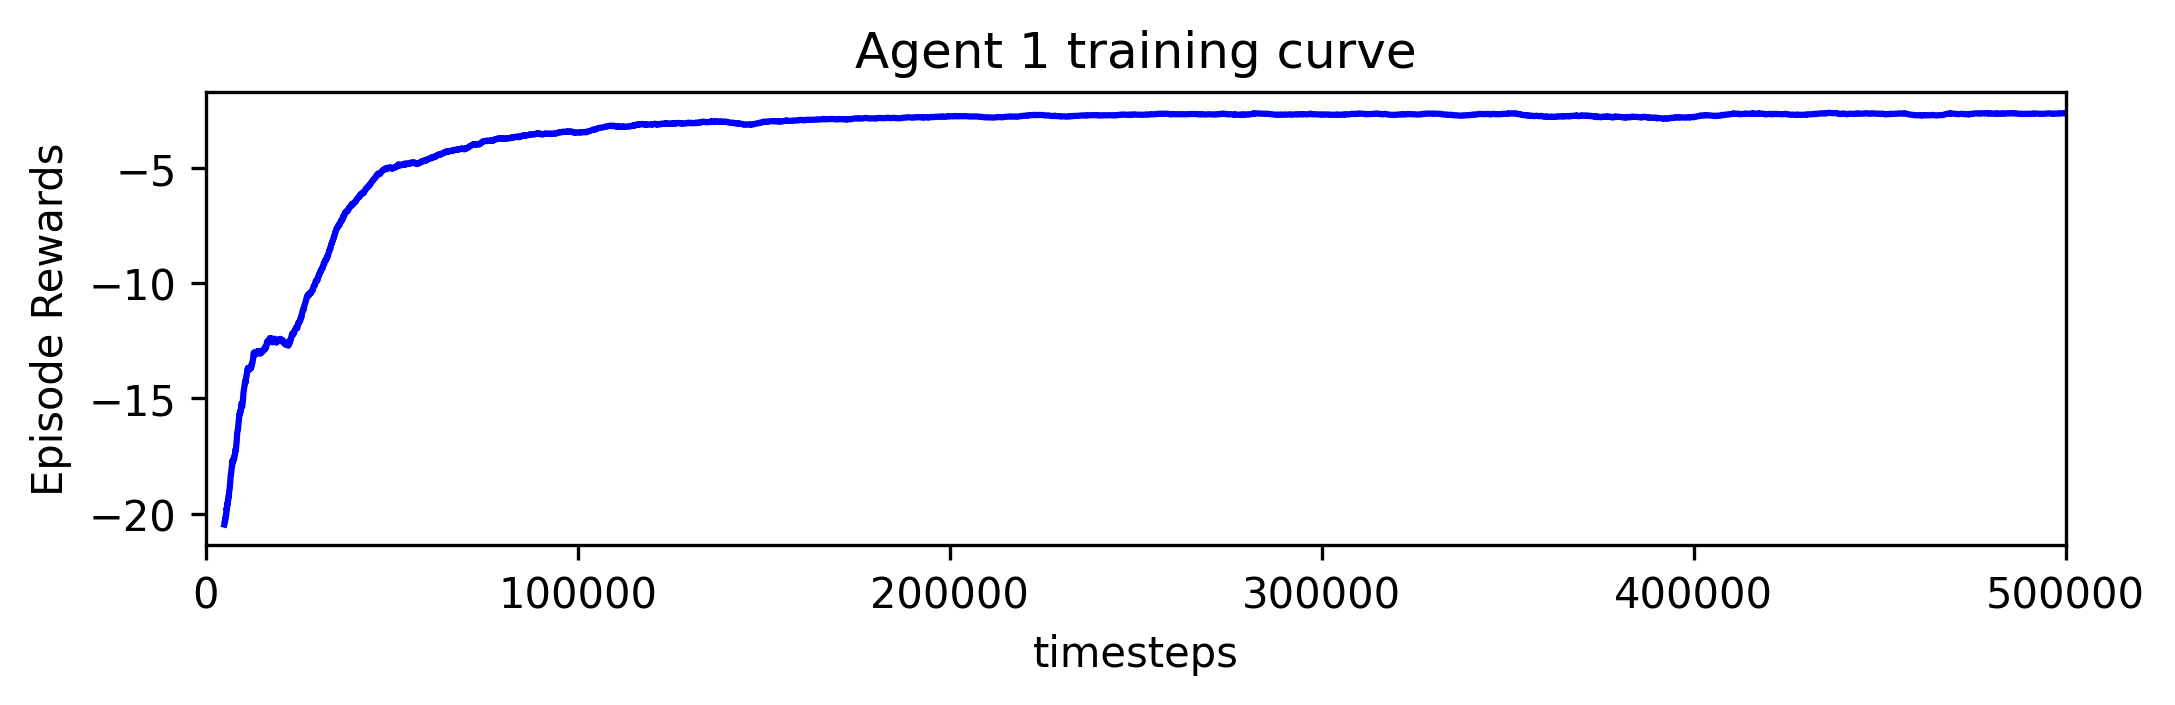

In [ ]:
log_dir = '../content/agent1/results/'
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

model_one = PPO('MultiInputPolicy', env, verbose=1, seed=1)
timesteps = 5e5
model_one.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent 1 training curve")
plt.show()

## Extracting layer weights of policy net

In [ ]:
policy_weights = get_weights(model_one, net='policy')

# Get weights of action net (i.e. actor layer of the policy)
action_weights = get_weights(model_one, net='action')
policy_weights.append(action_weights[0])

policy_weights_all = [policy_weights]
print([layer.shape for layer in policy_weights])

[(64, 16), (64, 64), (4, 64)]


## Testing

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

def plot_rewards(mean_reward, title=None):
    plt.figure(figsize=(10,5), dpi=300)
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards at episode')
    plt.xticks(list(range(1, len(mean_reward)+1)))
    plt.plot(list(range(1, len(mean_reward)+1)), mean_reward, marker='o')
    plt.show()

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=-2.69 +/- 0.19


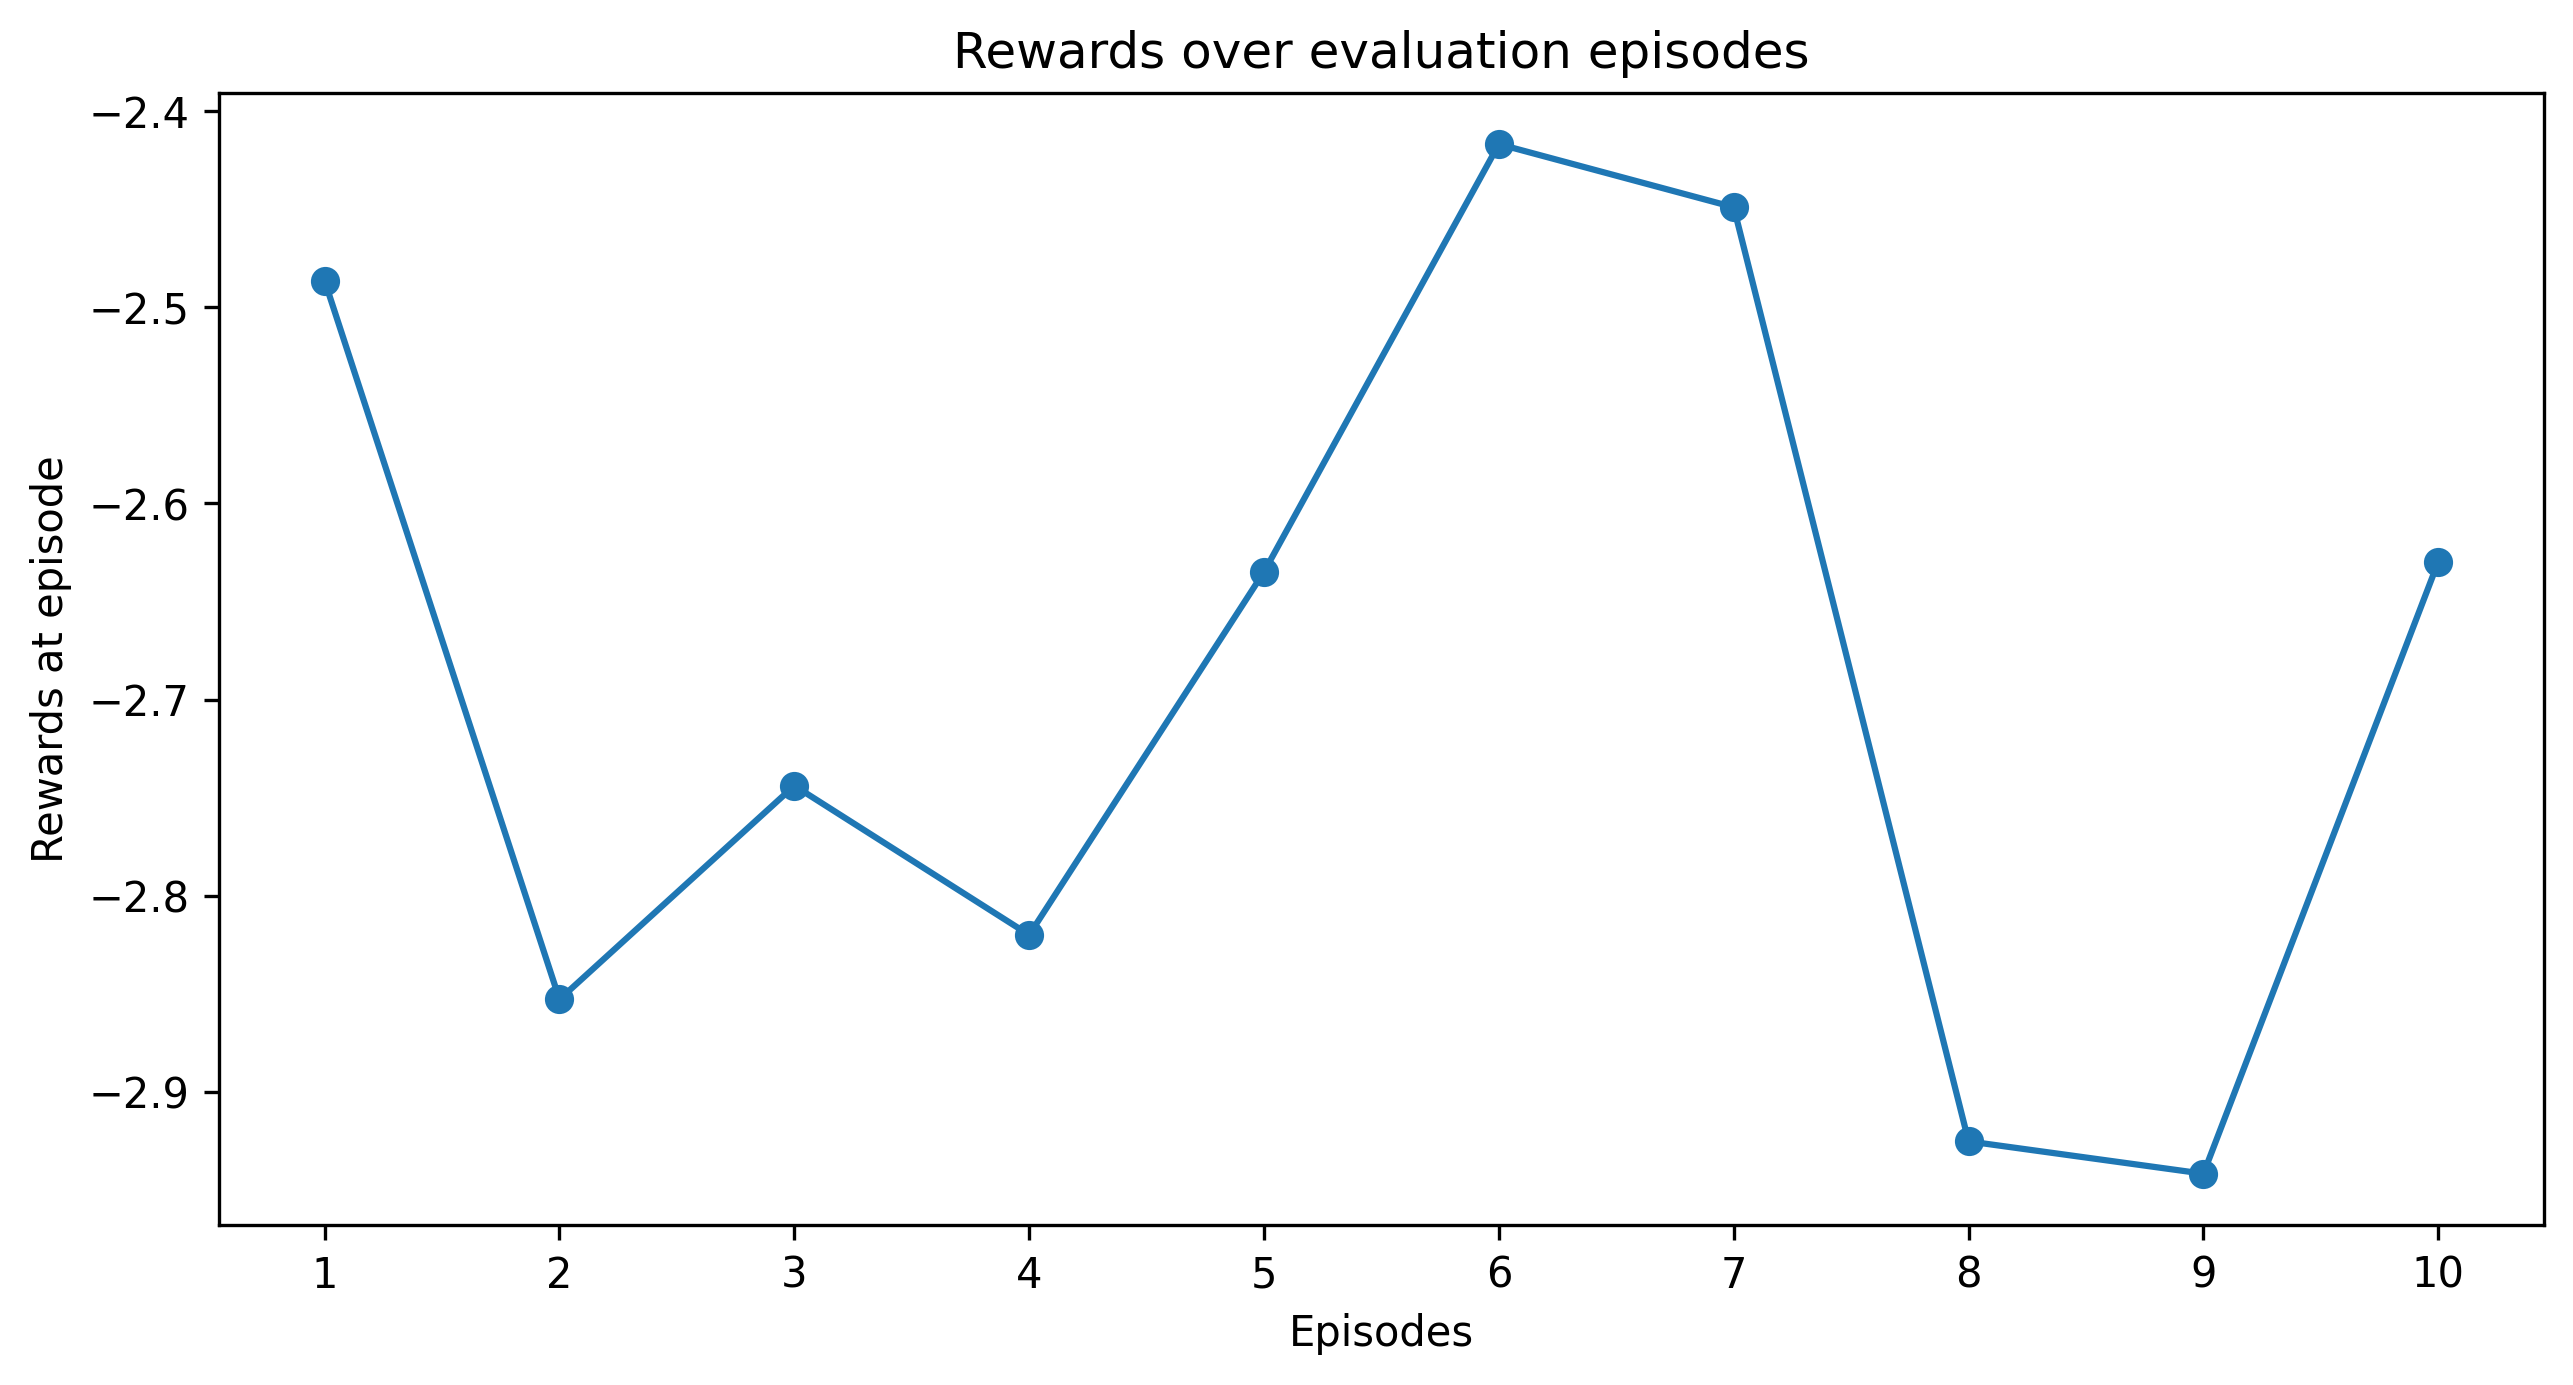

In [ ]:
import numpy as np

# Create separate evaluation environment
eval_env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_bottom_left, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

In [ ]:
os.makedirs('../content/agent1/rendering/', exist_ok=True)
render_agent_in_env(model_one, env, n_eval_episodes=1, path='../content/agent1/rendering/', filename='agent1')

RuntimeError: ignored

#Agent 2

## Configuring

Agent 2 will only be able to reach targets in the top right of the table.

In [ ]:
def custom_top_right(env):

  env._elapsed_steps = 0
  result = env.env.reset()

  # Configure goal location
  x = uniform(low=1.45, high=1.5)
  y = uniform(low=0.5, high=0.55)
  env.env.goal = np.array([x, y, 0.4])
  result['desired_goal'] = env.env.goal
  return result

In [ ]:
env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_top_right, env)
env.reset()

{'achieved_goal': array([1.34183265, 0.74910039, 0.53472272]),
 'desired_goal': array([1.47408761, 0.53546498, 0.4       ]),
 'observation': array([ 1.34183265e+00,  7.49100387e-01,  5.34722720e-01,  1.97805133e-04,
         7.15193042e-05,  7.73933014e-06,  5.51992816e-08, -2.42927453e-06,
         4.73325650e-06, -2.28455228e-06])}

## Training

Streaming output truncated to the last 5000 lines.
|    loss                 | -0.0197     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00173    |
|    std                  | 0.82        |
|    value_loss           | 0.0221      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -2.82       |
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 19          |
|    time_elapsed         | 128         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.012917031 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.85       |
|    explained_variance   | 0.333       |
|    learning_rate        | 0.0003      |
|    loss                

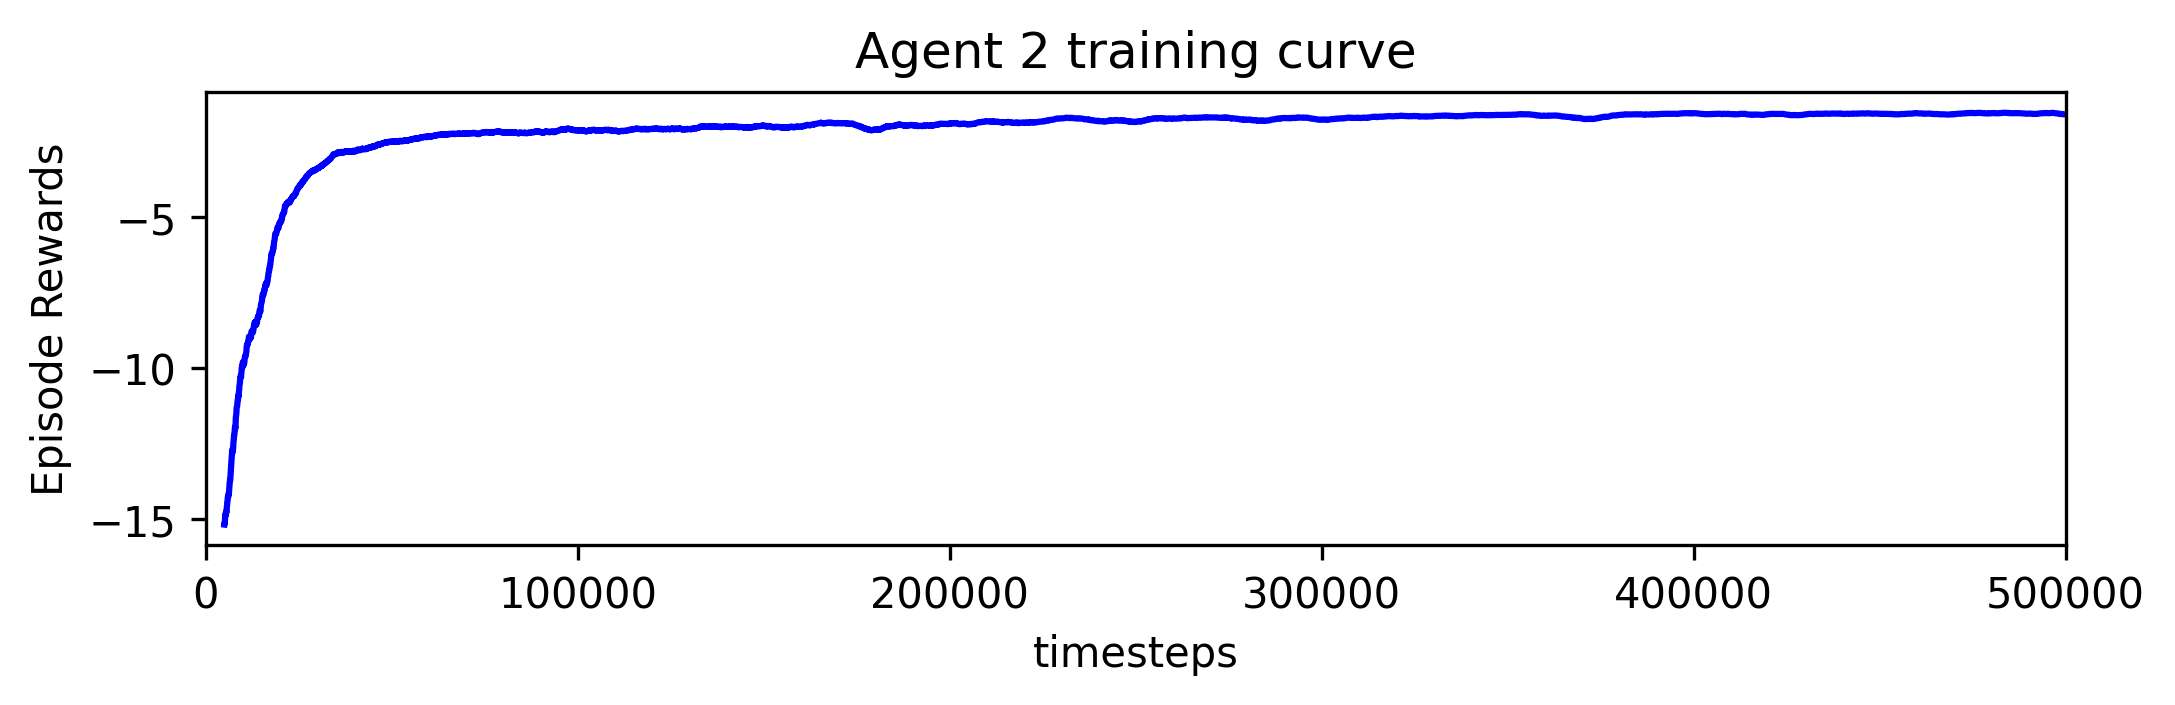

In [ ]:
log_dir = '../content/agent2/results/'
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

model_two = PPO('MultiInputPolicy', env, verbose=1, seed=1)
timesteps = 5e5
model_two.learn(total_timesteps=timesteps)

plot_training_curve([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Agent 2 training curve")
plt.show()

## Extracting layer weights of policy net

In [ ]:
policy_weights = get_weights(model_two, net='policy')
action_weights = get_weights(model_two, net='action')
policy_weights.append(action_weights[0])

policy_weights_all.append(policy_weights)
print([layer.shape for layer in policy_weights])

[(64, 16), (64, 64), (4, 64)]


## Testing

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=-1.48 +/- 0.07


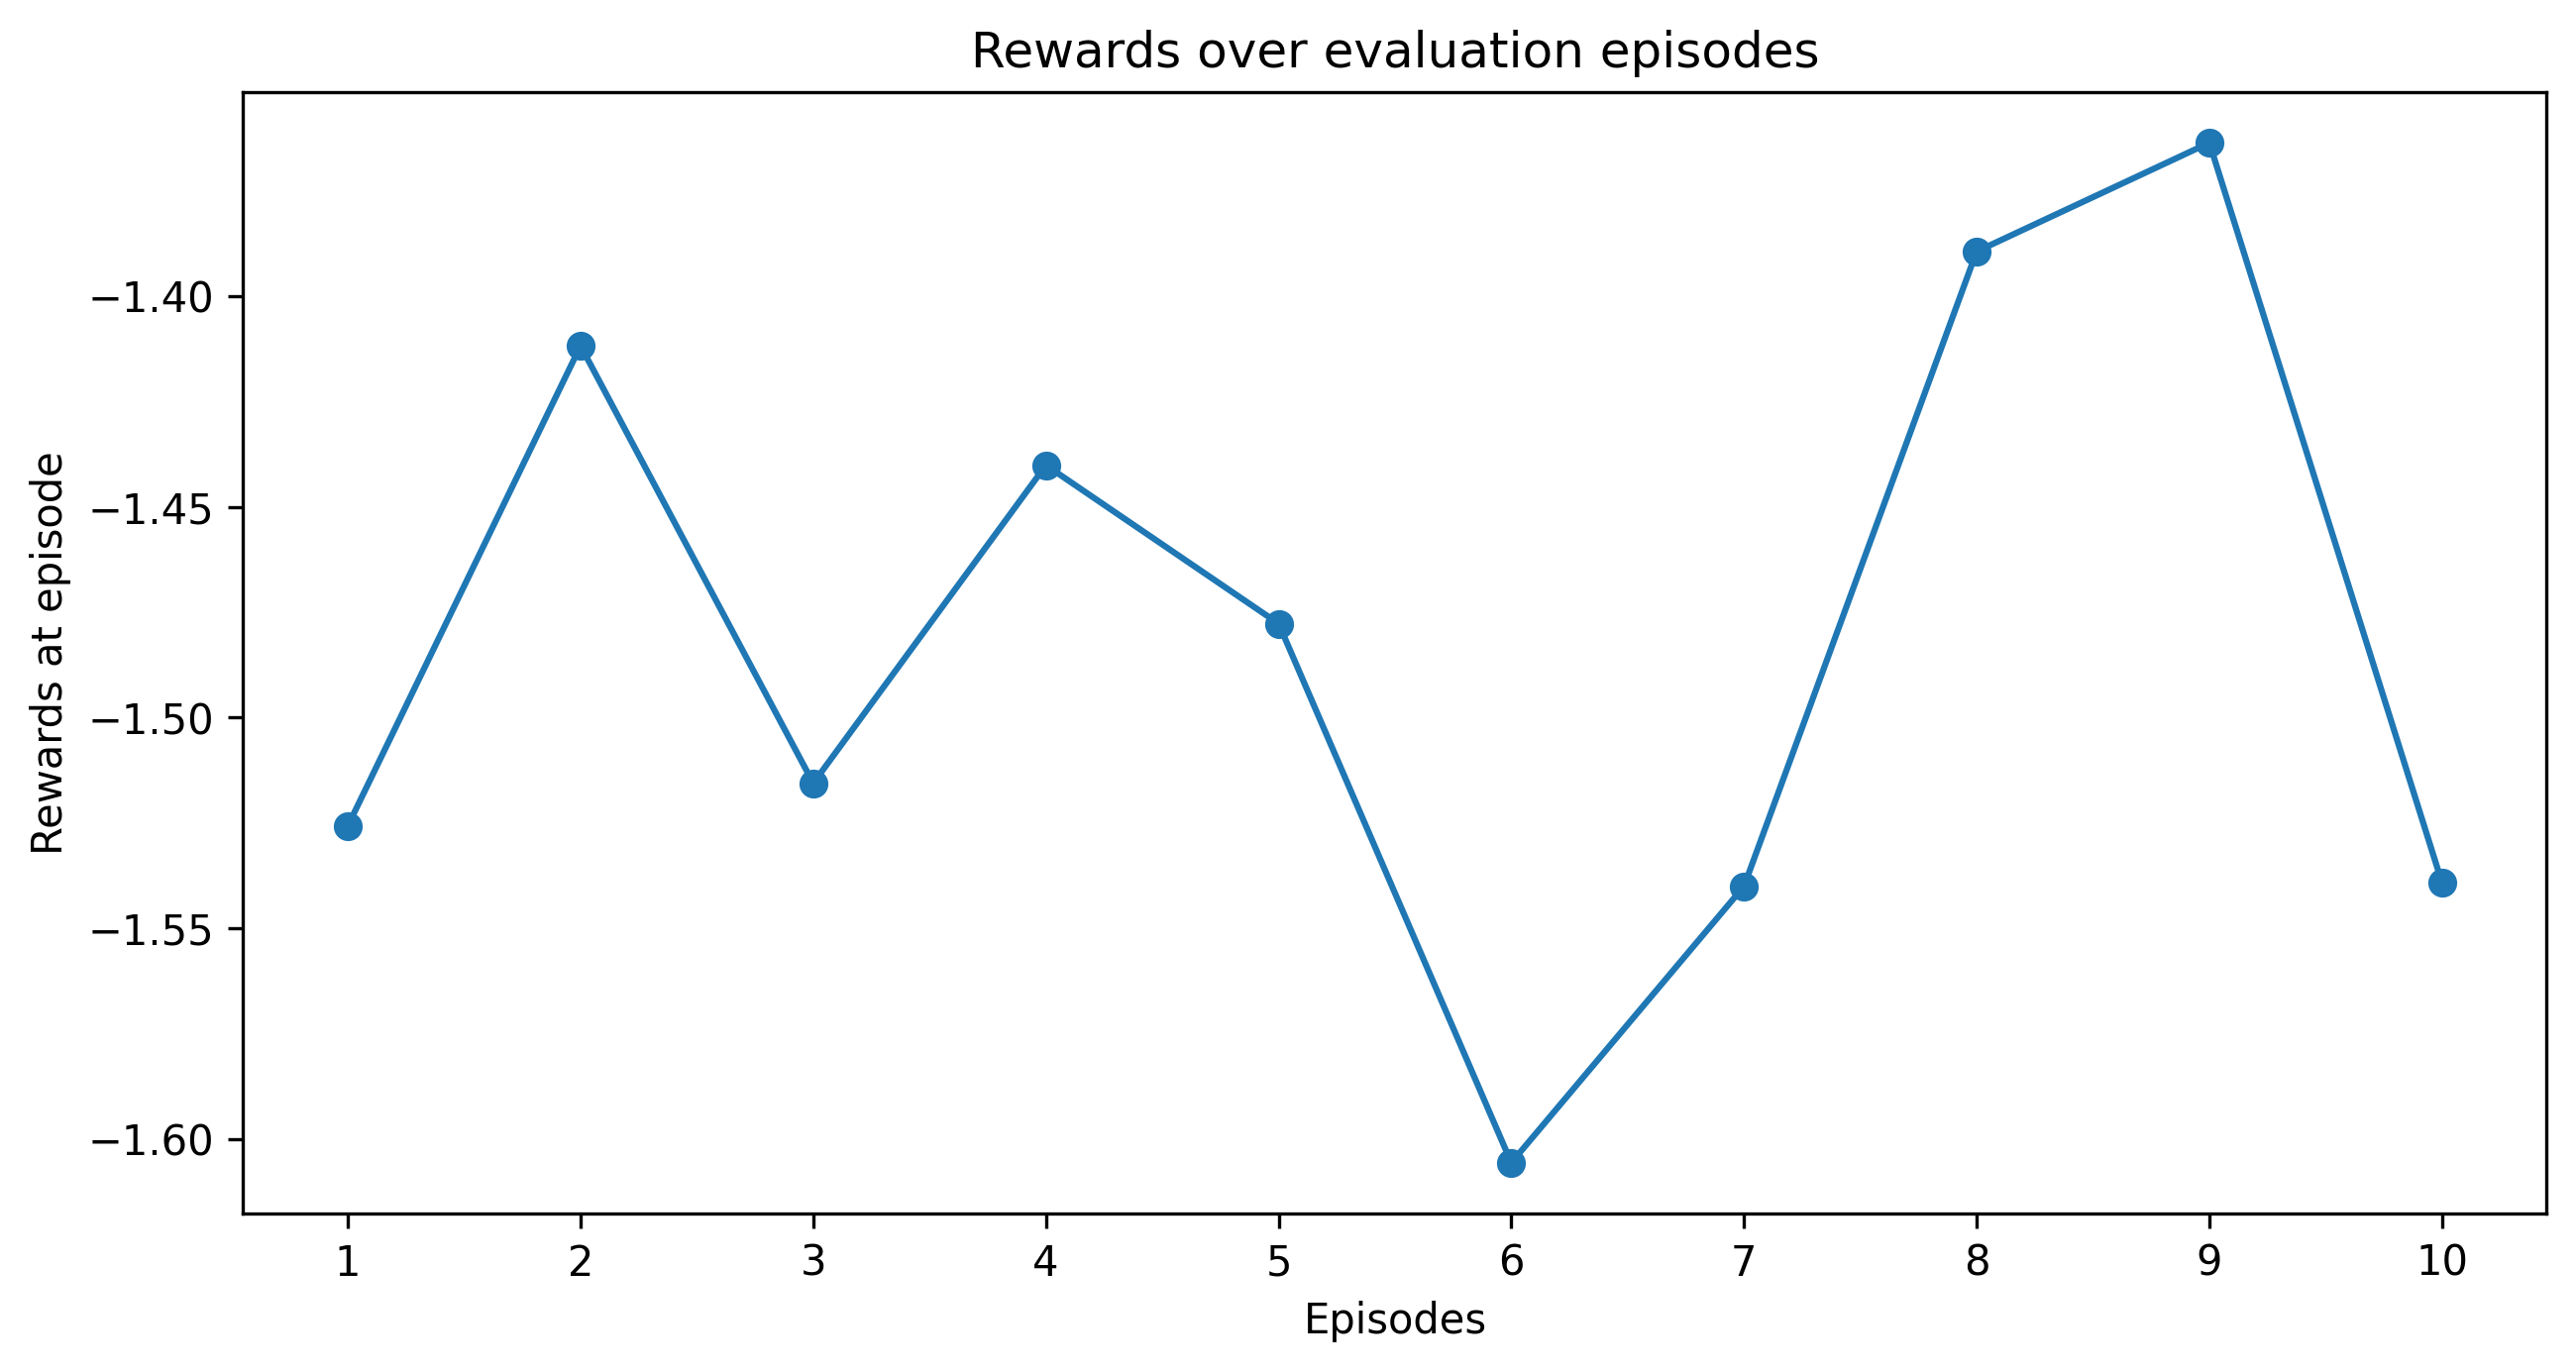

In [ ]:
# Create separate evaluation environment
eval_env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_top_right, eval_env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

Visualise the performance of the agent over a number of evaluation episodes.

In [ ]:
os.makedirs('../content/agent2/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=1, path='../content/agent2/rendering/', filename='agent2')

#Fuse the agents

## Align layers using OT

Compute the OT transport map between the weights, then align the matching nodes to each other using this map.

In [ ]:
# Install optimal transport requirements
!pip install pot
import ot

In [ ]:
def align_nodes(layer_weights_all, stop_layer_k=3):
    
    # Compute layer-wise transport maps
    for i in range(stop_layer_k):

        # Align other nets (source) to first net (target)
        for j in range(1, len(layer_weights_all)):
            Xs = layer_weights_all[j][i]
            Xt = layer_weights_all[0][i]

            # Reorganise source weights according to previous layer alignment
            if i > 0:
              for pos, w in enumerate(Xs):
                Xs[pos] = w[alignment_idx]

            # Compute optimal transport map using EMD, since matching whole nodes
            ot_emd = ot.da.EMDTransport()
            ot_emd.fit(Xs=Xs, Xt=Xt)

            # Get source net aligned to node positions of target net
            aligned_Xs = ot_emd.inverse_transform(Xt=Xt)

            # Replace original with aligned 
            layer_weights_all[j][i] = aligned_Xs

            # Save as previous layer alignment
            alignment_idx = []
            for w in range(Xs.shape[0]):
              idx = np.argwhere(aligned_Xs == Xs[w])[0][0]
              alignment_idx.append(idx)

    return layer_weights_all


aligned_policy_weights_all = align_nodes(policy_weights_all, stop_layer_k=3)

## Average layer weights

In [ ]:
def fuse_policy_weights(aligned_policy_weights_all):
    sum_weights = [np.add(aligned_policy_weights_all[0][0], 
                          aligned_policy_weights_all[1][0]), 
                   np.add(aligned_policy_weights_all[0][1], 
                          aligned_policy_weights_all[1][1]),
                   np.add(aligned_policy_weights_all[0][2],
                          aligned_policy_weights_all[1][2])]
    return [layer/2 for layer in sum_weights]


fused_policy_weights = fuse_policy_weights(aligned_policy_weights_all)

## Evaluate the fused model

The new domain is targets in the middle third of the table.

In [ ]:
def custom_middle(env):

  env._elapsed_steps = 0
  result = env.env.reset()

  # Configure goal location
  x = uniform(low=1.15, high=1.4)
  y = uniform(low=0.6, high=1)
  env.env.goal = np.array([x, y, 0.4])
  result['desired_goal'] = env.env.goal
  return result

In [ ]:
import torch as pt


def replace_policy(model, new_policy, new_actor):

    # Replace policy net with given policy
    policy = model.get_parameters().get('policy')
    policy['mlp_extractor.policy_net.0.weight'] = pt.from_numpy(new_policy[0])
    policy['mlp_extractor.policy_net.2.weight'] = pt.from_numpy(new_policy[1])
    policy['action_net.weight'] = pt.from_numpy(new_actor)
    updated_param = {'policy': policy}

    # Set policy parameter 
    model.set_parameters(updated_param, exact_match=False)
    return model


env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
env.reset()

# Make a new model from fused layers
log_dir = '../content/fused/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

fused_model = PPO('MultiInputPolicy', env, verbose=1, seed=1)
new_policy = fused_policy_weights[:-1]
new_actor = fused_policy_weights[-1]
fused_model = replace_policy(fused_model, new_policy, new_actor)

Using cpu device
Wrapping the env in a DummyVecEnv.


### Without retraining

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=-6.71 +/- 2.95


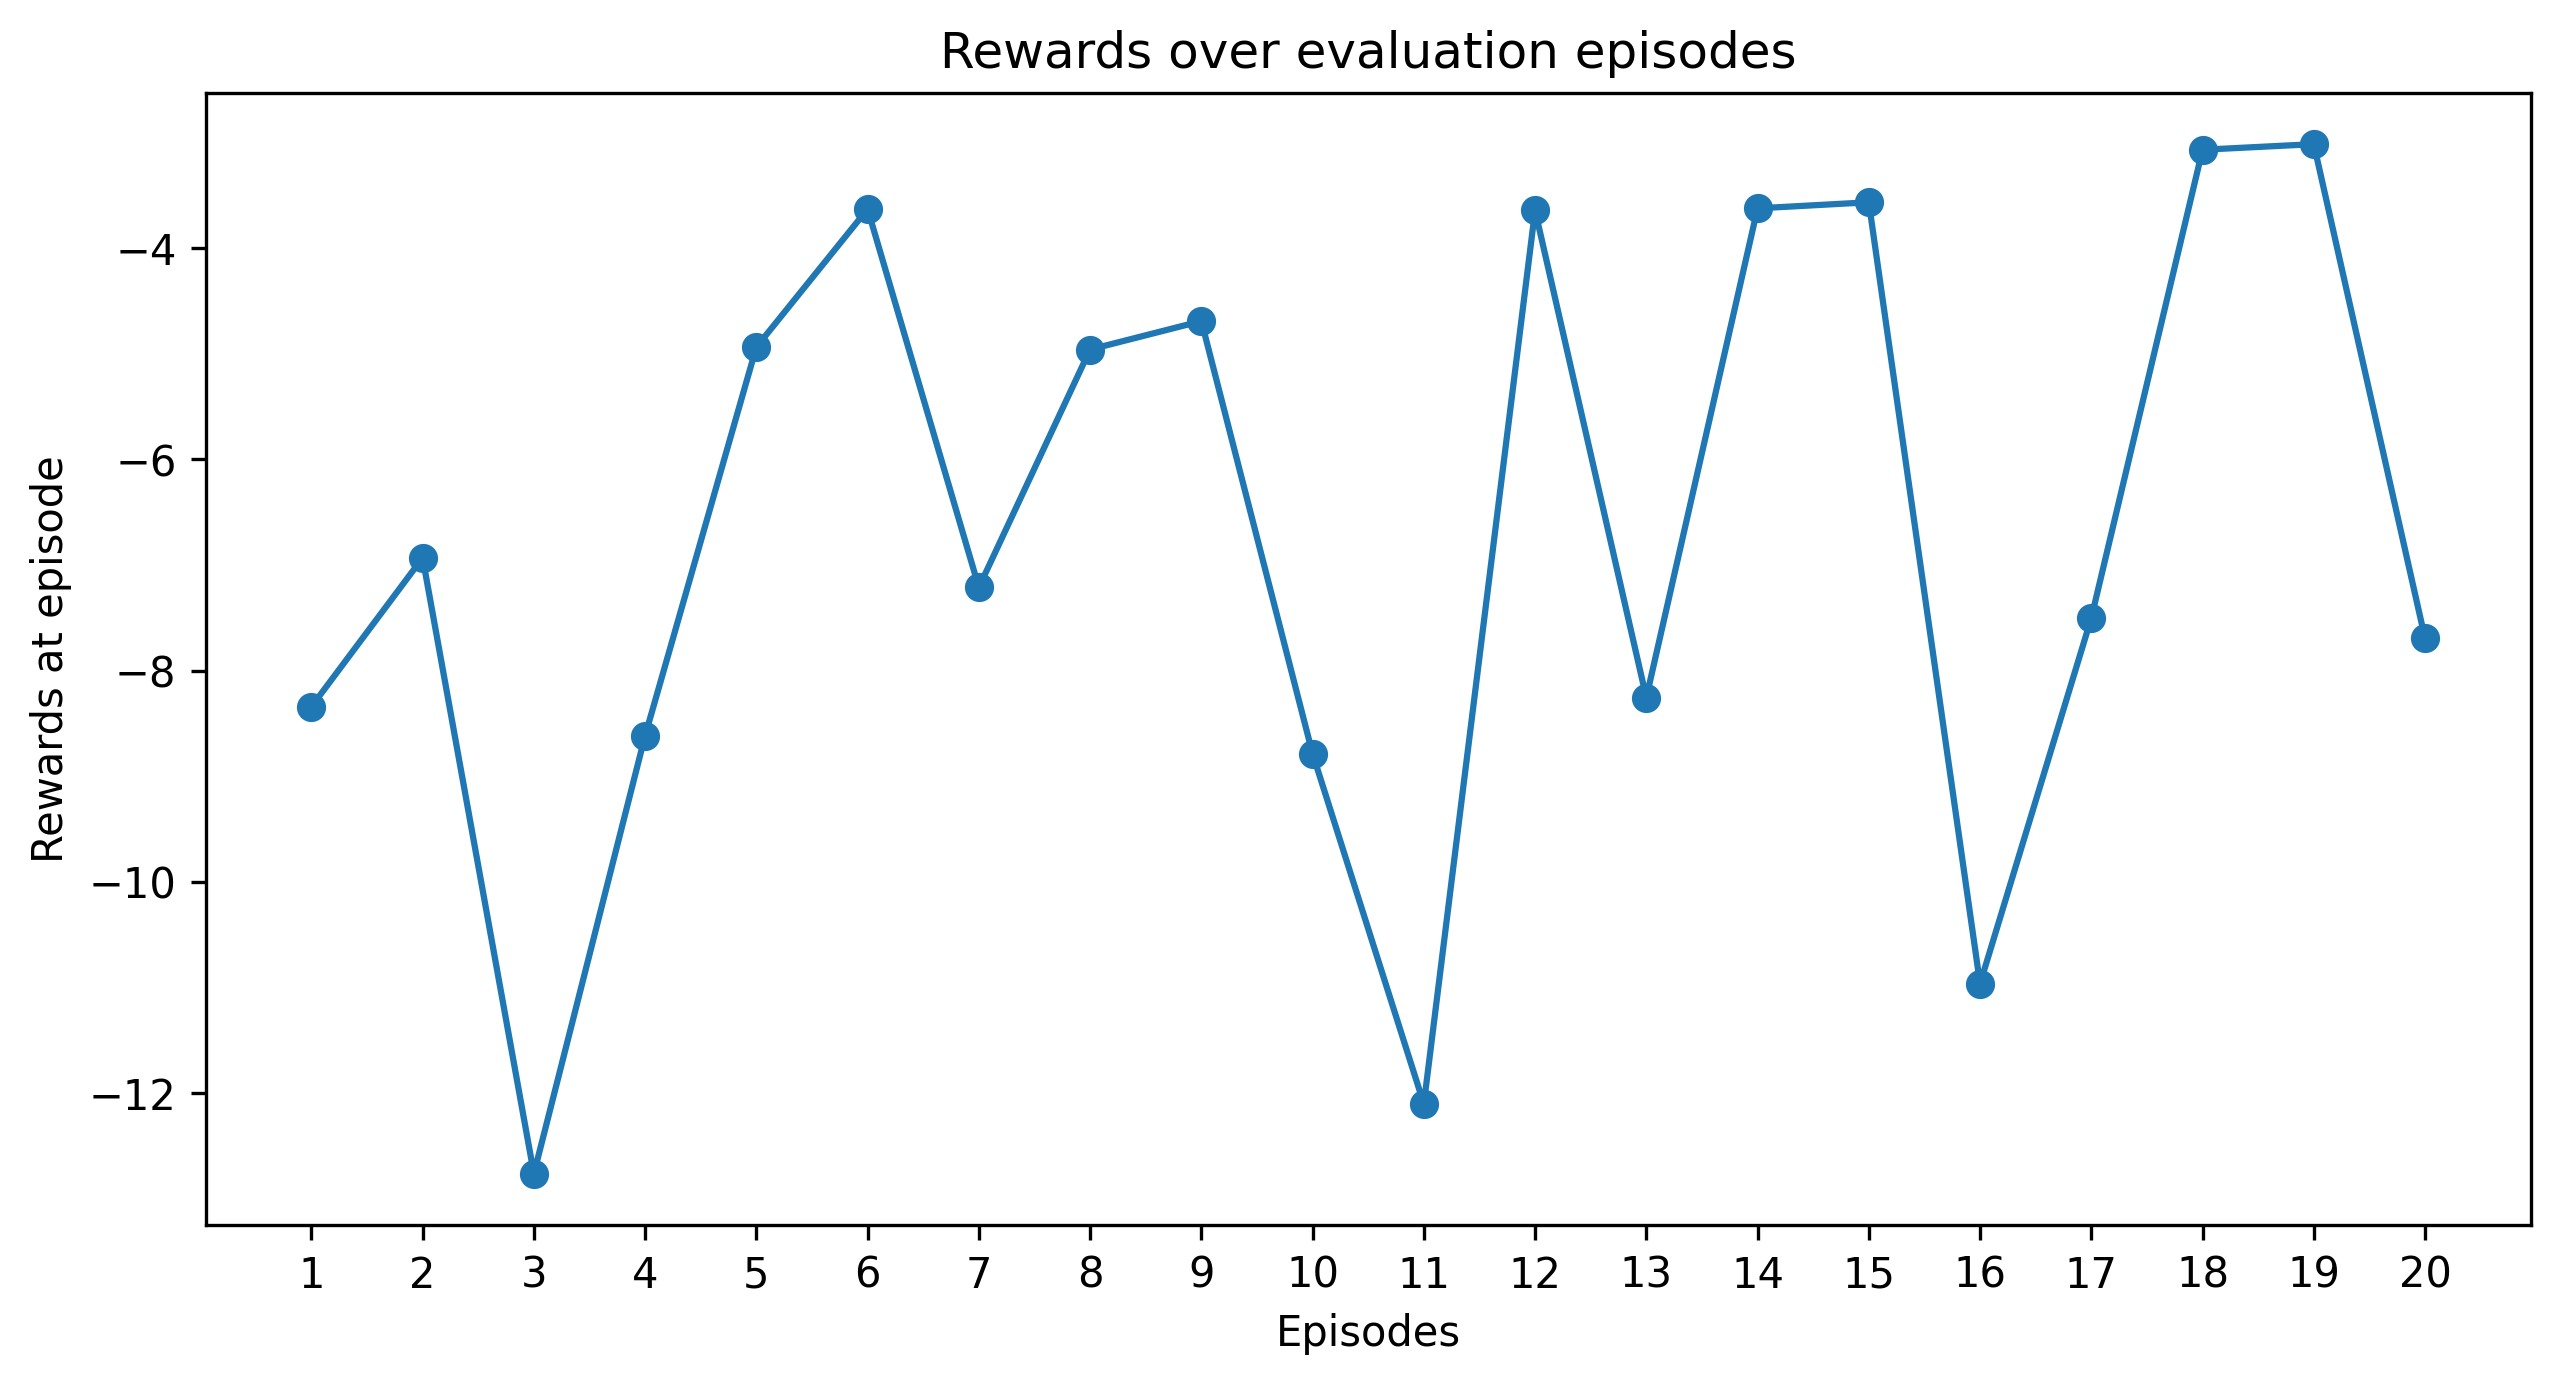

In [ ]:
# Create separate evaluation environment
eval_env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
eval_env.reset()

ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=20, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=1, path='../content/fused/rendering/', filename='untrained')

### With retraining

Retrain fused model to optimise weights.

In [ ]:
env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
env.reset()

log_dir = '../content/fused/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

fused_model.set_env(env)
timesteps = 2e5
fused_model.learn(total_timesteps=timesteps)

Compare to retraining original models.

In [ ]:
env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
env.reset()

log_dir = '../content/agent1/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_one.set_env(env)
timesteps = 2e5
model_one.learn(total_timesteps=timesteps)

In [ ]:
env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
env.reset()

log_dir = '../content/agent2/retraining/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

model_two.set_env(env)
timesteps = 2e5
model_two.learn(total_timesteps=timesteps)

Compare to training new model from scratch.

In [ ]:
env = gym.make('FetchReach-v1', reward_type='dense')
overwrite_method(custom_middle, env)
env.reset()

log_dir = '../content/new-agent/results/'
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

new_model = PPO('MultiInputPolicy', env, verbose=1, seed=1)
timesteps = 2e5
new_model.learn(total_timesteps=timesteps)

Plot all training curves on the same axes.

In [ ]:
all_dirs = ['../content/new-agent/results/', '../content/fused/retraining/results/', '../content/agent1/retraining/results/', '../content/agent2/retraining/results']
legend = ['new agent', 'fused agent', 'original agent 1', 'original agent 2']
plot_training_curve(all_dirs, timesteps, results_plotter.X_TIMESTEPS, "Agents retraining curves", legend=legend)

## Evaluation and rendering

Fused model:

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean reward=-8.03 +/- 3.47


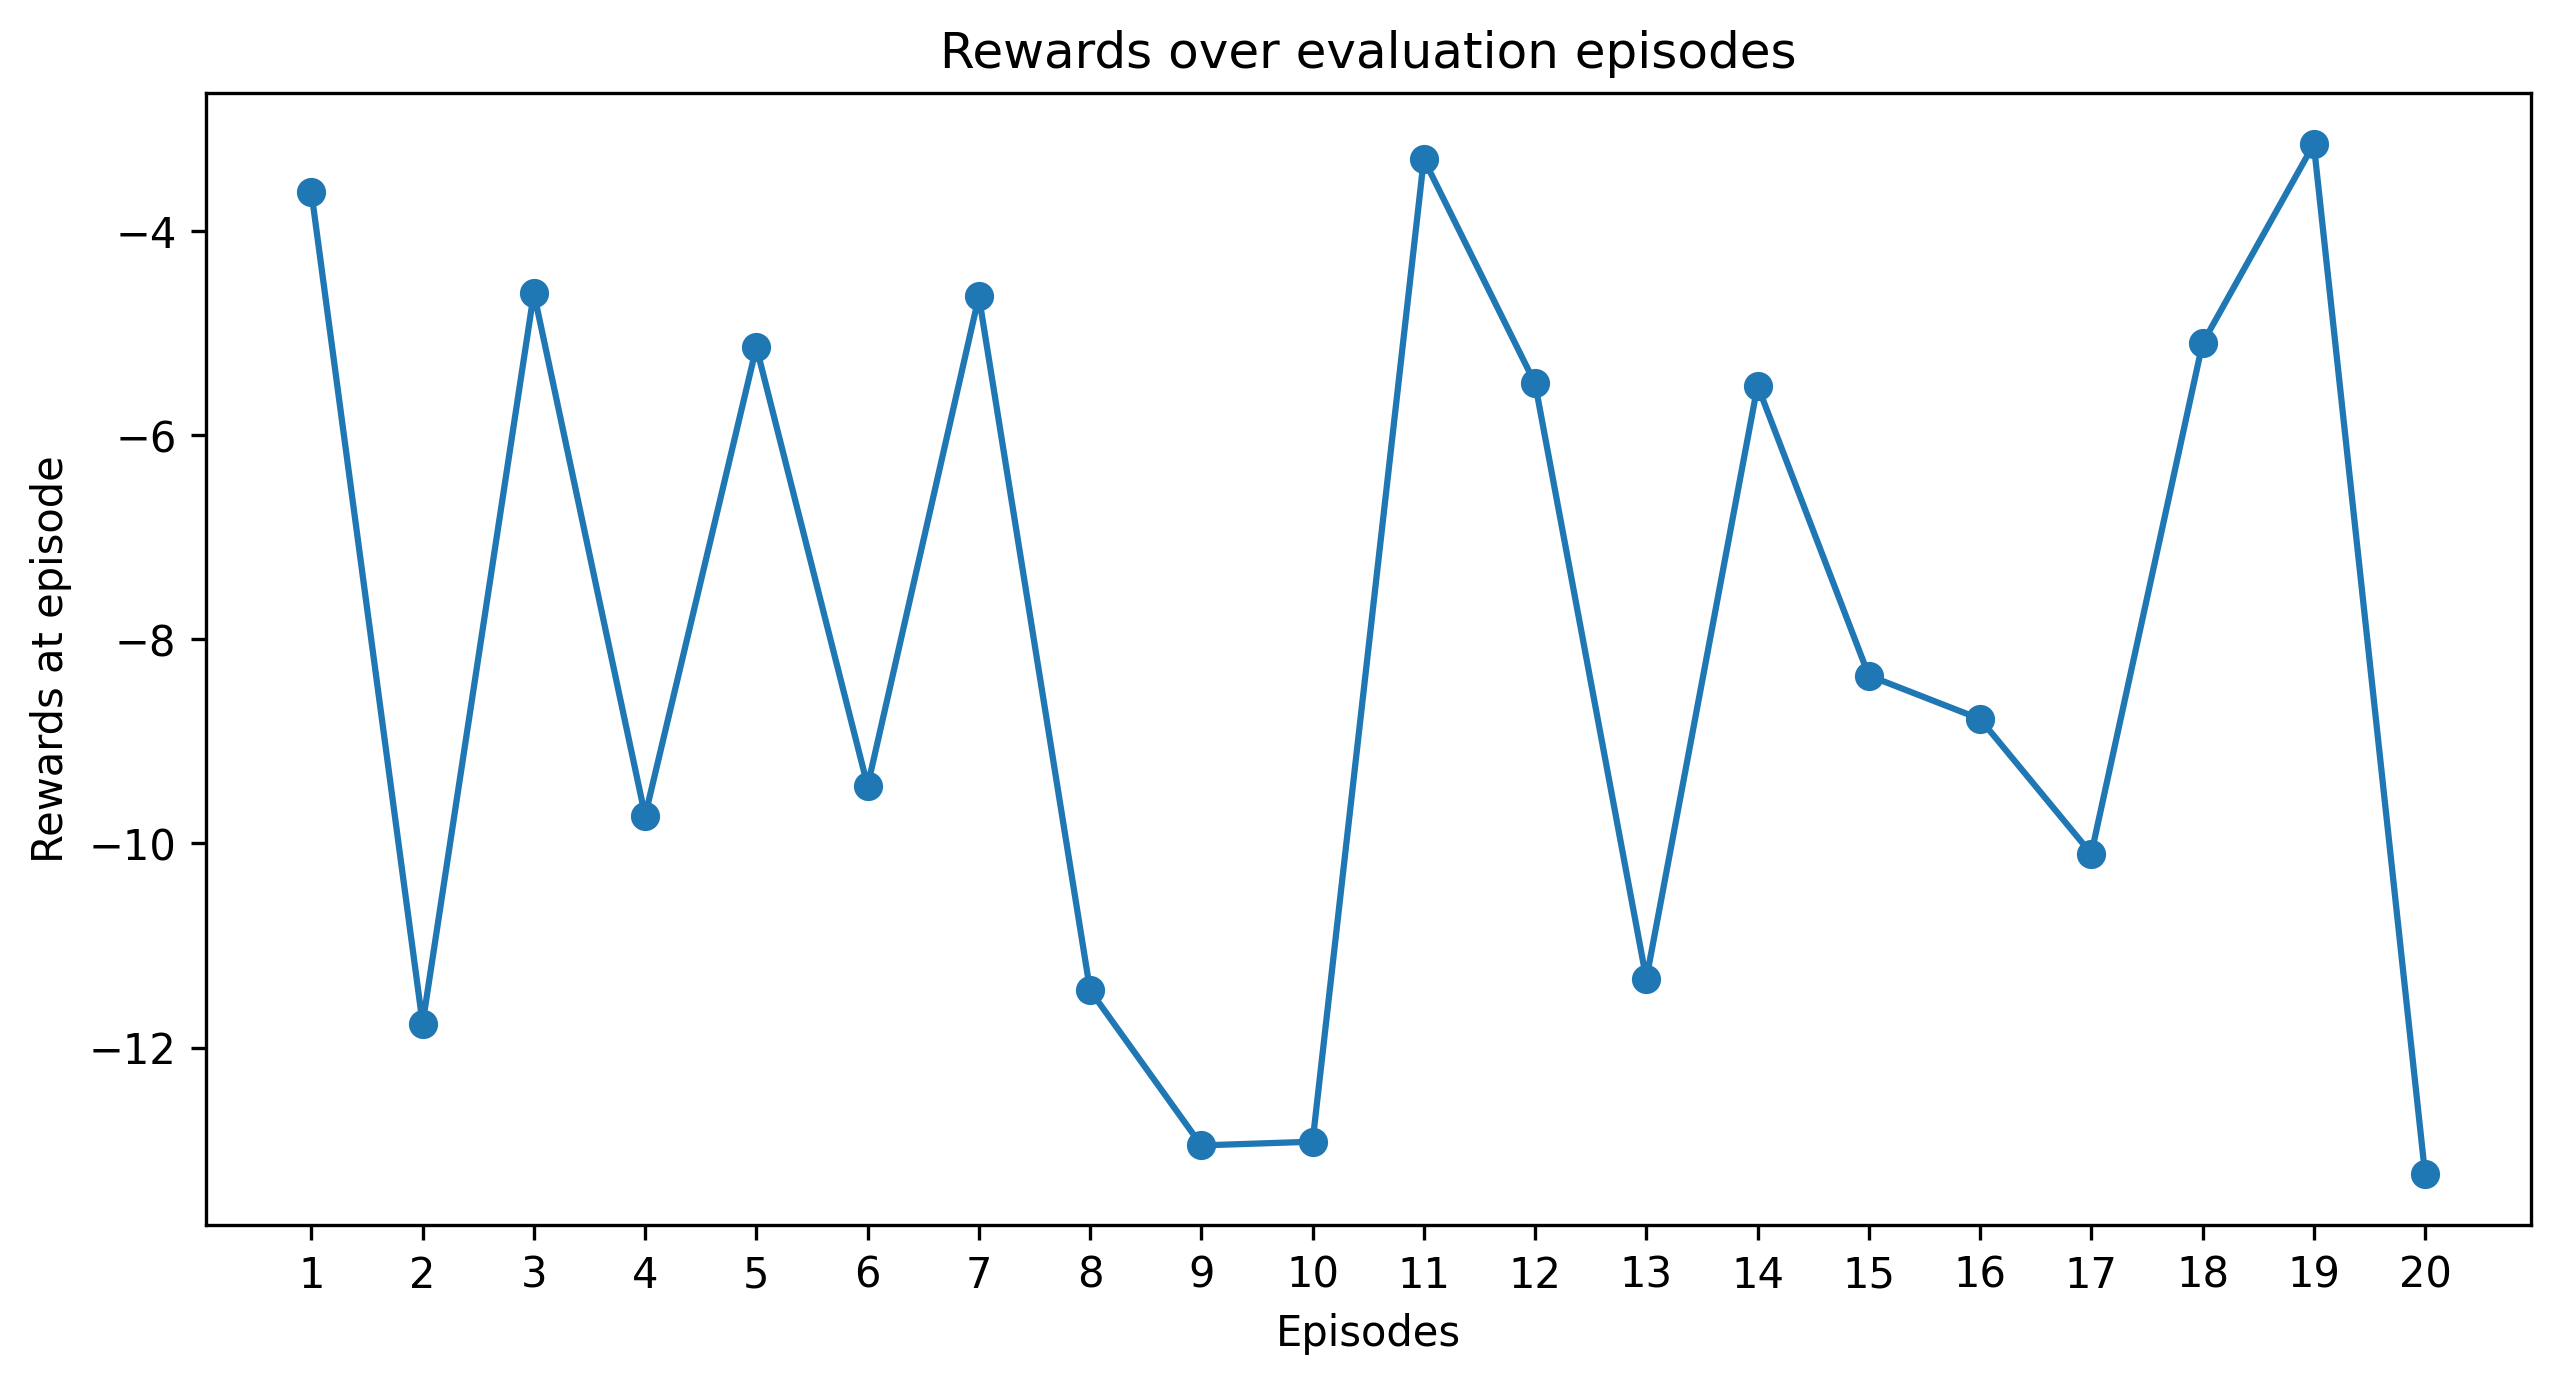

In [ ]:
ep_rewards, ep_steps = evaluate_policy(fused_model, eval_env, n_eval_episodes=20, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/fused/rendering/', exist_ok=True)
render_agent_in_env(fused_model, eval_env, n_eval_episodes=1, path='../content/fused/rendering/', filename='retrained')

New model:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(new_model, eval_env, n_eval_episodes=20, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/new-agent/rendering/', exist_ok=True)
render_agent_in_env(new_model, eval_env, n_eval_episodes=1, path='../content/new-agent/rendering/', filename='new-agent')

Retrained agent 1:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(model_one, eval_env, n_eval_episodes=20, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/agent1/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_one, eval_env, n_eval_episodes=1, path='../content/agent1/retraining/rendering/', filename='agent1-retrained')

Retrained agent 2:

In [ ]:
ep_rewards, ep_steps = evaluate_policy(model_two, eval_env, n_eval_episodes=20, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

In [ ]:
os.makedirs('../content/agent2/retraining/rendering/', exist_ok=True)
render_agent_in_env(model_two, eval_env, n_eval_episodes=1, path='../content/agent2/retraining/rendering/', filename='agent2-retrained')